# DGCCA for EHR dataset

## Train Model 

In [37]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.models import g_step, DeepGCCA
import pprint as pp
from dgcca.utils.compressor import qsgd
from dgcca.ehr.dataset_ehr import EhrDataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
import numpy as np
import math

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_ehr_cutemaxvar.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=True, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=250, help='')
parser.add_argument('--lr', default=0.0005, help='')
parser.add_argument('--device', default='cuda', help='')
parser.add_argument('--inner_epochs', default=10, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=4, help='')
parser.add_argument('--num_epochs', default=40, help='')
parser.add_argument('--n_trials', default=10, help='')
parser.add_argument('--test_size', default=200, help='')


args = vars(parser.parse_args(args = []))
pp.pprint(args)



device = torch.device(args['device'])
num_workers = 5
loss_func = nn.MSELoss

num_batches = math.ceil(527/args['batch_size'])
acc = np.zeros( (2, args['n_trials'], args['num_epochs']))

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_frequent',
                            shuffle=True)
mat = ehr_dataset.x[:, :-args['test_size'], :]
test_data = ehr_dataset.x[:, -args['test_size']:, :]
test_views = [item.double() for item in test_data]
y_test = ehr_dataset.y[-args['test_size']:]
y_train = ehr_dataset.y[:-args['test_size']]

# Set the random seed
torch.manual_seed(int(args['random_seed']))
layer_sizes_list = 3*[[512,256,128,64,10]]
input_size_list = 3*[mat[0].shape[1]]

compression_exp = [True, False]

# bits_schedule = [6,6,6,6]

for compress_id in range(len(compression_exp)):
    args['compress'] = compression_exp[compress_id]
    
    for trial_id in range(args['n_trials']):

        run_count = 0
        models = []
        run_data = []

        data_load_time = 0
        forward_time = 0

        indices = list(np.arange(mat[0].shape[0]))

        dgcca = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca = dgcca.to(device)

        train_views = [item.double().to('cpu') for item in mat]
    #     train_views = list(ehr_dataset.x.to(device))
        optimizer = torch.optim.Adam(dgcca.parameters(), lr=args['lr'])

        J = train_views[0].shape[0]

        criterion = loss_func()

        # init G
        dgcca.eval()
        dgcca = dgcca.to('cpu')
        out = dgcca(train_views)
        out = torch.stack(out)  
        out -= out.mean(dim=1).unsqueeze(dim=1)
        G = g_step(out.clone().detach())  
        M_serv = out.clone()
        M_diff = out.clone()
        dgcca.train()
        G_serv = G.clone()
        
        dgcca = dgcca.to(device)
        for epoch in trange(args['num_epochs']):
            total_recons_loss = 0
            total_val_loss = 0
            batch_count = 0
#             if epoch < 5:
#                 args['nbits'] = 4
#             else:
#                 args['nbits'] = 4
                
            for j in range(args['inner_epochs']):
    #             for i in range(num_batches):
                optimizer.zero_grad()
                batch = []

    #             batch_id = i%(num_batches)
    #             print(batch_id)
                # SGD
    #                 try:
    #                     batch = [view[(batch_id*args['batch_size']):((batch_id+1)*args['batch_size']), :] for view in train_views]            
    #                     target = G_serv[(batch_id*args['batch_size']):((batch_id+1)*args['batch_size']), :]
    #                 except:
    #                     batch = [view[(batch_id*args['batch_size']):, :] for view in train_views]            
    #                     target = G_serv[(batch_id*args['batch_size']):, :]

                # SGD
                rand_samp = random.sample(indices, args['batch_size'])
                batch = [view[rand_samp,:].to(device) for view in train_views]
                target = G[rand_samp, :].to(device)

                out = dgcca(batch)
                out = torch.stack(out)  

                loss = 1/2*torch.norm(out-target)/target.shape[0]

                loss.backward()
                optimizer.step()

                total_recons_loss += loss.item()
                del batch, target
            ## Update G
            dgcca = dgcca.to('cpu')
            dgcca.eval()
            out = dgcca(train_views)
            out = torch.stack(out)
            if args['compress']:
                for i in range(len(train_views)):
                    M_diff[i] = out[i] - M_serv[i]
                    max_val = M_diff[i].abs().max()

                    if args['compression_scheme'] == 'qsgd':
                        M_quant = qsgd(M_diff[i], n_bits=args['nbits'])
                    else:
                        M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)

                    M_serv[i] += M_quant
                    M_serv[i] -= M_serv[i].mean(dim=0)
                    del M_quant, max_val
                G = g_step(M_serv.clone().detach()) 
                G_serv = G_serv + qsgd(G-G_serv, n_bits=args['nbits'])
            else:
                out = out - out.mean(dim=1).unsqueeze(dim=1)
                G = g_step(out.clone().detach())  
            del out
            dgcca.train()

            # classification for distributed method
            clf = svm.SVC(kernel='rbf')
            clf.fit(G.to('cpu').numpy(), y_train)

            results = OrderedDict()
            results['epoch'] = epoch
            results['data_fidelity'] = total_recons_loss
            results['lr'] = args['lr']
            results['device'] = device

            dgcca = dgcca.to('cpu')
            out = torch.stack(dgcca(test_views))  
            out -= out.mean(dim=1).unsqueeze(dim=1)
            G_test = g_step(out.to('cpu').clone().detach())  

            results['class_acc'] = accuracy_score(y_test.numpy(), clf.predict(G_test.numpy()))
            dgcca = dgcca.to(device)
            acc[compress_id, trial_id, epoch] = results['class_acc']

            run_data.append(results)
            df_alt = pd.DataFrame.from_dict(run_data, orient='columns')
            clear_output(wait=True)
            display(df_alt)

            torch.save(dgcca, args['model_dest'])



,epoch,data_fidelity,lr,device,class_acc
0,0,0.339022,0.0005,cuda,0.300
1,1,0.142819,0.0005,cuda,0.420
2,2,0.104469,0.0005,cuda,0.560
3,3,0.082270,0.0005,cuda,0.605
4,4,0.075758,0.0005,cuda,0.655
5,5,0.071450,0.0005,cuda,0.660
6,6,0.068198,0.0005,cuda,0.710
7,7,0.065134,0.0005,cuda,0.685
8,8,0.063115,0.0005,cuda,0.720
9,9,0.060148,0.0005,cuda,0.735


100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


## Plot Accuracy 

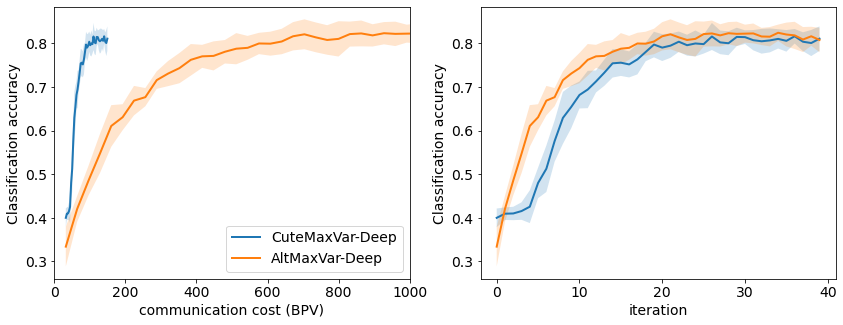

In [38]:
acc = {'cute': acc[0], 'alt': acc[1]}


fig, axes = plt.subplots(1,2, figsize=(14,5))


cute_mean = acc['cute'].mean(axis=0)
alt_mean = acc['alt'].mean(axis=0)
cute_std = acc['cute'].std(axis=0)
alt_std = acc['alt'].std(axis=0)

comm_cute = np.arange(len(cute_mean))*3 + 32
comm_alt = np.arange(len(cute_mean))*32 + 32

axes[0].plot(comm_cute, acc['cute'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_cute, cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[0].plot(comm_alt, acc['alt'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_alt, alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[0].legend(['CuteMaxVar-Deep', 'AltMaxVar-Deep'], fontsize=14)
axes[0].set_xlabel('communication cost (BPV)', fontsize=14)
axes[0].set_ylabel('Classification accuracy', fontsize=14)
axes[0].set_xlim(0, 1000)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)



axes[1].plot(acc['cute'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(cute_mean)), cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[1].plot(acc['alt'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(alt_mean)), alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[1].set_xlabel('iteration', fontsize=14)
axes[1].set_ylabel('Classification accuracy', fontsize=14)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

## Plot TSNE 

Text(0.5, 1.0, 't-SNE plot of latent representation G')

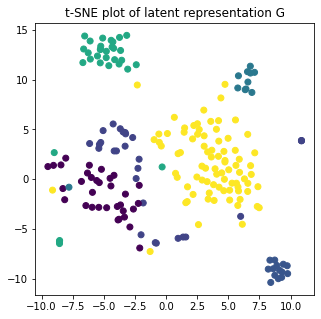

In [39]:
import numpy as np
from sklearn.manifold import TSNE

test_views= ehr_dataset.x[:,-args['test_size']:, :]

# dgcca.eval()
dgcca = dgcca.to('cpu')
out = dgcca(list(test_views.double()))
out = torch.stack(out)
out = out - out.mean(dim=1).unsqueeze(dim=1)
G_test = g_step(out.clone().detach())

data = G_test

X = data.to('cpu').numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1, figsize=(5,5))

sc = axes.scatter(X_embedded[:,0], X_embedded[:,1], c=ehr_dataset.y[-args['test_size']:])

axes.set_title('t-SNE plot of latent representation G')


## Classification 

In [40]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

dgcca_dist = torch.load('trained_models/dgcca_ehr_cutemaxvar1.model')
dgcca_alt = torch.load('trained_models/dgcca_ehr_altmaxvar1.model')

train_data = ehr_dataset.x[:, :-200, :]
train_views = [item.double() for item in train_data]
test_data = ehr_dataset.x[:, -200:, :]
test_views = [item.double() for item in test_data]

dgcca_dist.eval()
dgcca_dist = dgcca_dist.to('cpu')
dgcca_alt.eval()
dgcca_alt = dgcca_alt.to('cpu')

# prepare train data
out = torch.stack(dgcca_dist(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_alt = g_step(out.clone().detach())  

# prepare test data
out = torch.stack(dgcca_dist(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_alt = g_step(out.clone().detach())  


y_train = ehr_dataset.y[:-200]
y_test = ehr_dataset.y[-200:]

# classification for distributed method
clf_dist = svm.SVC(kernel='rbf')
clf_dist.fit(x_train_dist, y_train)

# classification for non-distributed method
clf_alt = svm.SVC(kernel='rbf')
clf_alt.fit(x_train_alt, y_train)

# classification for the raw view
clf_raw = svm.SVC(kernel='rbf')
clf_raw.fit(train_views[0], y_train)


acc_dist = accuracy_score(y_test, clf_dist.predict(x_test_dist))
acc_alt = accuracy_score(y_test, clf_alt.predict(x_test_alt))
acc_raw = accuracy_score(y_test, clf_raw.predict(test_views[0]))

acc_dist, acc_alt, acc_raw

(0.895, 0.895, 0.41)

## tsne plot (raw, gcca, alt, dist)

Text(0.5, 0, 'Classification Acc. 80.0 %')

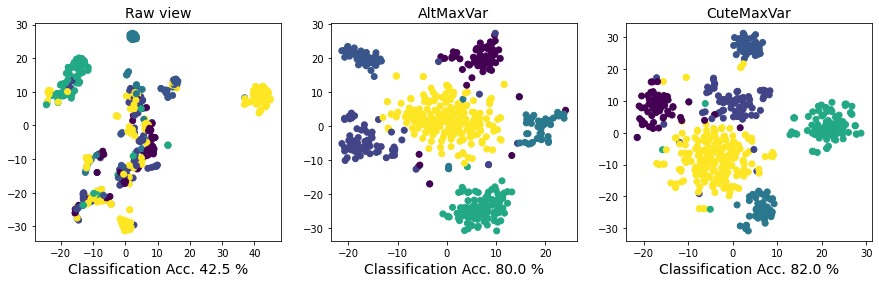

In [41]:
import numpy as np
from sklearn.manifold import TSNE

dgcca_dist = torch.load('trained_models/dgcca_ehr_cutemaxvar1.model')
dgcca_alt = torch.load('trained_models/dgcca_ehr_altmaxvar1.model')

test_size = 500

train_data = ehr_dataset.x[:, :-test_size, :]
train_views = [item.double() for item in train_data]
test_data = ehr_dataset.x[:, -test_size:, :]
test_views = [item.double() for item in test_data]

dgcca_dist.eval()
dgcca_dist = dgcca_dist.to('cpu')
dgcca_alt.eval()
dgcca_alt = dgcca_alt.to('cpu')

# prepare train data
out = torch.stack(dgcca_dist(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(train_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_train_alt = g_step(out.clone().detach())  

# prepare test data
out = torch.stack(dgcca_dist(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_dist = g_step(out.clone().detach())   

out = torch.stack(dgcca_alt(test_views))  
out -= out.mean(dim=1).unsqueeze(dim=1)
x_test_alt = g_step(out.clone().detach())  

y_train = ehr_dataset.y[:-test_size]
y_test = ehr_dataset.y[-test_size:]


# Tsne embeddings

x_embedded_raw = test_views[0].to('cpu').numpy()
x_embedded_raw = TSNE(n_components=2).fit_transform(x_embedded_raw)


x_embedded_dist = x_test_dist.to('cpu').numpy()
x_embedded_dist = TSNE(n_components=2).fit_transform(x_embedded_dist)

x_embedded_alt = x_test_alt.to('cpu').numpy()
x_embedded_alt = TSNE(n_components=2).fit_transform(x_embedded_alt)


fig, axes = plt.subplots(1,3, figsize=(15, 4))

axes[0].scatter(x_embedded_raw[:,0], x_embedded_raw[:,1], c=y_test)
axes[0].set_title('Raw view', fontsize=14)
axes[0].set_xlabel('Classification Acc. 42.5 %', fontsize=14)

axes[2].scatter(x_embedded_dist[:,0], x_embedded_dist[:,1], c=y_test)
axes[2].set_title('CuteMaxVar', fontsize=14)
axes[2].set_xlabel('Classification Acc. 82.0 %', fontsize=14)


axes[1].scatter(x_embedded_alt[:,0], x_embedded_alt[:,1], c=y_test)
axes[1].set_title('AltMaxVar', fontsize=14)
axes[1].set_xlabel('Classification Acc. 80.0 %', fontsize=14)



# axes.set_title('t-SNE plot of latent representation G')

In [70]:
fig.savefig('../plt/ehr_dataset_tsne_plot.pdf')